In [1]:
# Required Packages
import pandas as pd

# preprocessing
from sklearn import preprocessing

# Modeling
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

# Progress Bar
import progressbar

# Plots

import seaborn as sns
import matplotlib.pyplot as plt

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

![title](https://upload.wikimedia.org/wikipedia/commons/5/51/IBM_logo.svg)

# IBM HR Analytics Employee Attrition & Performance

In this study, we analyze HR data available from   [kaggle.com](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) 

This data is **fictional** and it is created by IBM data scientists.

Categorical Parameters:

|                           |       1       |    2    |     3     |      4      |    5   |
|:-------------------------:|:-------------:|:-------:|:---------:|:-----------:|:------:|
|         Education         | Below College | College |  Bachelor |    Master   | Doctor |
|  Environment Satisfaction |      Low      |  Medium |    High   |  Very High  |        |
|      Job Involvement      |      Low      |  Medium |    High   |  Very High  |        |
|      Job Satisfaction     |      Low      |  Medium |    High   |  Very High  |        |
|     Performance Rating    |      Low      |   Good  | Excellent | Outstanding |        |
| Relationship Satisfaction |      Low      |  Medium |    High   |  Very High  |        |
|      WorkLife Balance     |      Bad      |   Good  |   Better  |     Best    |        |

#### Table of contents

* [Modeling](#Modeling)
    * [Correlation](#Correlation)
    * [Training and testing sets](#Training-and-testing-sets)
    * [Final words](#Final-words)

### Loading the Data

In [2]:
Data = pd.read_excel('Data/WA_Fn-UseC_-HR-Employee-Attrition.xlsx')
Data.head().style.hide_index()

Useful functions throughout this study

In [3]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr()
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("RdYlGn", n_colors=Correlation_Matrix.shape[1]),
                linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .5})
    bottom, top = ax.get_ylim()

In [4]:
def Search_List(Inp, MyList):
    ''' Search for specific value (Inp) in the column list '''
    Out=list()
    for i in MyList:
        if i.find(Inp) != -1:
            Out.append(i)
    return Out

# Modeling

We need to convert categorical data to numeric data.

In [5]:
Data.columns.to_series().groupby(Data.dtypes).groups

{dtype('int64'): Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
        'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
        'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
        'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
        'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
        'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager'],
       dtype='object'),
 dtype('O'): Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
        'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
       dtype='object')}

We can use **[LabelEncoder](#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)** for converting categorical to numeric using. Therefore,

In [6]:
df = Data.copy()
df = df.applymap(str)
Columns = df.columns.tolist()
# N is the number of columns
N = df.shape[1]

# Progressbar
Counter = 0
Progress_Bar = progressbar.ProgressBar(maxval= N, widgets=[progressbar.Bar('=', '|', '|'), progressbar.Percentage()])

#--------------- the loop ----------------------
Progress_Bar.start()
for i in range(N):
    if df[Columns[i]].dtype == 'object':
        le = preprocessing.LabelEncoder()
        le.fit(list(df.iloc[:,i]))
        df.iloc[:, i] = le.transform(df.iloc[:, i])
        del le
    Progress_Bar.update(Counter)
    Counter+=1
Progress_Bar.finish()
#--------------- End of the loop ---------------

# Finally, converting values of df back to integers.
df = df.astype(int)

|=========================================================================|100%


In [7]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int32'): Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
        'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
        'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
        'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
        'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
        'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
        'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
        'YearsWithCurrManager'],
       dtype='object')}

## Correlation

In [8]:
Correlations = pd.DataFrame(df.corr()['Attrition'].sort_values())
Correlations = Correlations.rename(columns={'Attrition': 'Correlation'}, errors="raise")
Correlations.head(8)

Correlation
JobLevel                -0.169105
Age                     -0.159205
YearsWithCurrManager    -0.150433
YearsInCurrentRole      -0.141640
StockOptionLevel        -0.137145
JobInvolvement          -0.130016
YearsAtCompany          -0.125120
JobSatisfaction         -0.103481

In [9]:
Correlations.tail(8)

Correlation
Department        0.063991
JobRole           0.067151
MaritalStatus     0.162070
OverTime          0.246118
Attrition         1.000000
EmployeeCount          NaN
Over18                 NaN
StandardHours          NaN

Thus, we can remove the last three columns

In [10]:
Correlations[Correlations['Correlation'].isnull()].index.tolist()

['EmployeeCount', 'Over18', 'StandardHours']

In [11]:
df = df.drop(columns= Correlations[Correlations['Correlation'].isnull()].index.tolist())

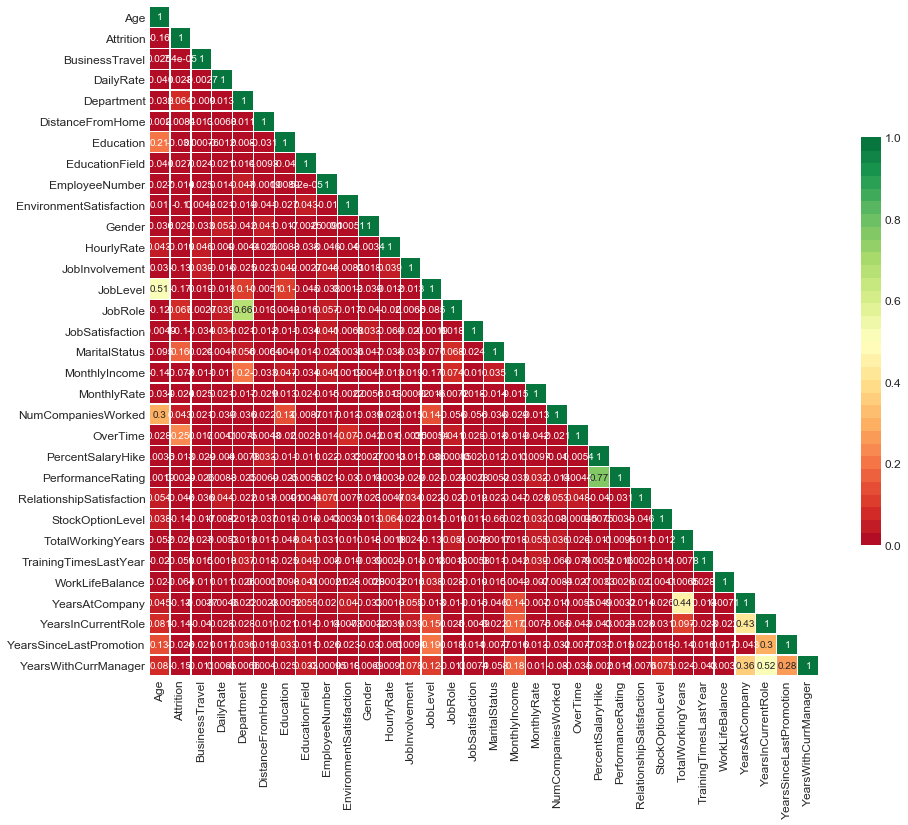

In [12]:
Correlation_Plot(df, 15)

## Training and testing sets

We also don't need **EmployeeNumber** for this part of our study. Hence,

In [13]:
Temp = df.drop(columns = ['EmployeeNumber'])
X = Temp.drop(columns = ['Attrition'])
y = Temp['Attrition']
del Temp

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [15]:
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
             'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).style.hide_index()

For the next part, we use ROC (receiver operating characteristic curve) AUC (Area Under the ROC Curve) mean and standard deviations for demonstrating a classification model (See more [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)).

In [16]:
Dict = {'Decision Tree Regression': DecisionTreeRegressor(),
        'Logistic Regression': LogisticRegression(solver='liblinear', random_state=10, class_weight='balanced'),
        'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=10),
        'Decision Tree Classifier': DecisionTreeClassifier(random_state=10),
        'Gaussian NB': GaussianNB()}

# Creating a Table
Results = pd.DataFrame(columns = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD'])

Mtds = list(Dict.keys())
kfold = model_selection.KFold(n_splits=20, random_state=10)

# Start ------------------------------------------------------------------
Progress_Bar = progressbar.ProgressBar(maxval=len(Mtds),
                                       widgets=[progressbar.Bar('=', '|', '|'), progressbar.Percentage()])
Progress_Bar.start()

for i in range(len(Mtds)):
    model_name = Mtds[i]
    model = Dict[model_name]
    Temp = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    Temp1 = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    Results.loc[i] = [model_name, round(Temp1.mean()*100, 2), round(Temp1.std()*100, 2),
                         round(Temp.mean()*100, 2), round(Temp.std()*100, 2)]
    Progress_Bar.update(i)
Progress_Bar.finish()
# End ------------------------------------------------------------------
del i, model, model_name, Dict, Temp, Temp1
Results = Results.sort_values(by=['ROC AUC Mean'], ascending=False)
Results.style.hide_index()

|=========================================================================|100%


Therefore,

# Final words

In [17]:
clf =  LogisticRegression(solver='liblinear', random_state=10, class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
def Prediction(Inp, Model = clf):
    Temp = df[df.EmployeeNumber==Inp]
    Temp = Temp.drop(columns = ['EmployeeNumber', 'Attrition'])
    Out = Model.predict(Temp)
    if Out == 1:
        Out ='Yes'
    else:
        Out = 'No'
    return Out

For example, the **Attrition** value for the following two employees will be

In [19]:
Prediction(997)

'Yes'

In [20]:
Prediction(120)

'No'

***